## <b>Solving 2d Poisson equation via Phycisc Informed Neural Networks (PINNs)<b>

This notebook gives an example of how to solve 2d Poisson equation via Phycisc Informed Neural Network (PINN) and TensorFlow (TF) and `tf.GradientTape`. 

For a detailed description of the method, as well as to have further details, please refer to the <a href=https://github.com/maziarraissi/PINNs>following repo</a>, and to:
<ul>
  <li>Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. <a href=https://www.sciencedirect.com/science/article/pii/S0021999118307125>Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations</a> Journal of Computational Physics 378 (2019): 686-707.</li>
  <li>Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. <a href=https://arxiv.org/abs/1711.10561>Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations</a> arXiv preprint arXiv:1711.10561 (2017).</li>
  <li>Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. <a href=https://arxiv.org/abs/1711.10566>Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations</a> arXiv preprint arXiv:1711.10566 (2017).</li>
</ul> 

Import the required libraries.

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from matplotlib import pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

from datetime import datetime
from time import time

from matplotlib import path

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

We consider the Poisson equation on the unit disk $\mathcal{D}$:
$$
\begin{align}
    \nabla^2\phi & = 1 && \in \mathcal{D},\\
    \phi & = 0 \quad && \in \partial\mathcal{D},
\end{align}
$$
where $\partial\mathcal{D}$ is the boundary of $\mathcal{D}$. The analytical solution of this equartion is:
$$
\phi(x,y) = \frac{1 - x^2  - y^2}{4}
$$

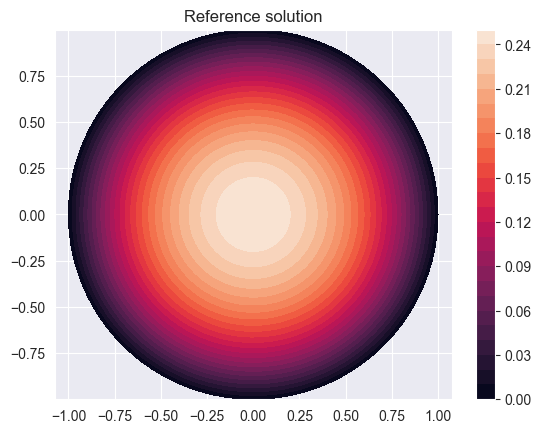

In [2]:
rr = np.linspace(0,1,50)
theta = np.linspace(0,2*np.pi,100)

RR,THETA = np.meshgrid(rr,theta)
xx,yy = RR*np.cos(THETA),RR*np.sin(THETA)
f = 1 # source term
def f_ref(x,y,f):
    return .25*(np.power(f,2)-np.power(x,2)-np.power(y,2))

plt.figure()
plt.contourf(xx,yy,f_ref(xx,yy,f),30)
plt.axis('equal')
plt.colorbar()
plt.title('Reference solution')
plt.show()

Define a set of *collocation poits*, i.e., the points where we are going to enforce that the derivatives of the network will satisfy the Poisson's equation.

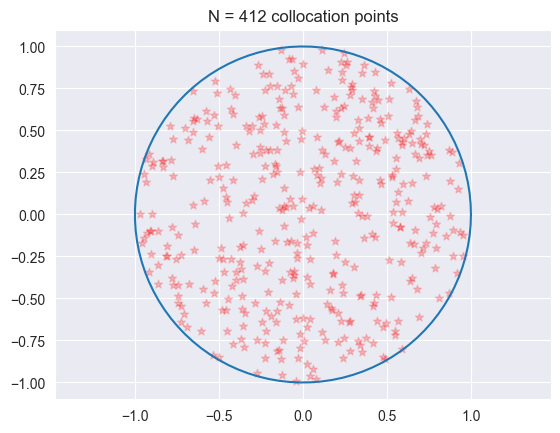

In [3]:
rr = 1
theta = np.linspace(0,2*np.pi,100)
boundary = np.column_stack((rr*np.cos(theta),rr*np.sin(theta)))
p = path.Path(boundary)  # square with legs length 1 and bottom left corner at the origin

scaler = MinMaxScaler(feature_range=(-1, 1))
N_rand_1 = 20
N_rand = round(4/np.pi*N_rand_1**2)

coll_pts = np.column_stack((scaler.fit_transform(np.random.rand(N_rand).reshape(-1,1)),
                          scaler.fit_transform(np.random.rand(N_rand).reshape(-1,1))))

coll_pts = coll_pts[p.contains_points(coll_pts),:]
# abs(100*(coll_pts.shape[0]-N_rand_1**2))/N_rand_1**2

plt.figure()
plt.plot(boundary[:,0],boundary[:,1])
plt.scatter(coll_pts[:,0],coll_pts[:,1], c='r', marker='*', alpha=0.2)
plt.axis('equal')
plt.title('N = ' + str(coll_pts.shape[0]) + ' collocation points')
plt.show()

Define the input/output for training the the Deep Neural Network (DNN), i.e., `X_train` are the $(x,y)$ coordinates of the boundary points and `y_train` are the values of the function at these points. Moreover, we define also `X_r`, the vector of the $(x,y)$ coordinates of the collocation points.

In [4]:
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)

rr = 1
theta = np.linspace(0,2*np.pi,200)
X_train = np.column_stack((rr*np.cos(theta),rr*np.sin(theta)))

y_train = f_ref(X_train[:,0],X_train[:,1],f).reshape(-1,1)

X_r    = tf.constant(coll_pts, dtype=DTYPE)  # -> collocation points
X_train = tf.constant(X_train, dtype=DTYPE)   # -> boundary points
y_train = tf.constant(y_train, dtype=DTYPE)  #-> values of function at boundary points


n_input = 2
n_output = 1

Define the Neural Network model and the routines for the custom cost function `PINN_cost`.

In [5]:
# Define residual of the PDE
def fun_r(u_xx, u_yy):
    return u_xx + u_yy + f



def get_r(model, X_r):
    with tf.GradientTape() as g:
        x,y = X_r[:,-2], X_r[:,-1]
        g.watch(x)
        with tf.GradientTape(persistent=False) as gg:
            gg.watch(x)
            u = model(tf.stack([x, y], axis=1))
        u_x = gg.gradient(u, x)  
    u_xx = g.gradient(u_x, x) 
    del g, gg
    
    with tf.GradientTape() as g:
        x,y = X_r[:,-2], X_r[:,-1]
        g.watch(y)
        with tf.GradientTape(persistent=False) as gg:
            gg.watch(y)
            u = model(tf.stack([x, y], axis=1))
        u_y = gg.gradient(u, y)  
    u_yy = g.gradient(u_y, y) 
    del g, gg
    
    return fun_r(u_xx, u_yy)



def PINN_cost(y_true, y_pred):  
    # Compute phi^r
    r = get_r(model, X_r)
    loss_PDE = tf.reduce_mean(tf.square(r))
        
    # loss = tf.reduce_mean(tf.square(y_true - y_pred))
    loss_DNN = tf.reduce_mean(tf.square(y_true - y_pred))
    loss = loss_PDE + loss_DNN
    
    return loss



def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(n_input,))

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('swish'),
            kernel_initializer=tf.keras.initializers.HeNormal(seed=None)))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

Now initialize the model, define some settings and create a dataset divided in a certain number of batches with with dimension equal to `batch_size`.

In [6]:
model = init_model()
loss_object = PINN_cost
optimizer = tf.keras.optimizers.Adam()

# Create a train datased via tf.data.Dataset.from_tensor_slices by specifying the batch_size 
batch_size = round(.2*X_train.shape[0])
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(X_train.shape[0]).batch(batch_size)


Define the fuction `train_step` which perform a single step of the training. This is done via `tf.GradientTape`, the TF record operation for automatic differentiation.

In [7]:
# this is the fucntion that
# with tf.device("/gpu:"""):
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=False)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Output the loss 
    train_loss = tf.reduce_mean(tf.keras.metrics.mean_squared_error(labels, predictions))
    return train_loss

Define the trainig loop for a given numebr of epochs and for all tha batches of the dataset.

In [8]:
EPOCHS = 500

model_loss = []
t_0 = datetime.now()

for epoch in range(EPOCHS):
    t_i_start = time()
    # training over all batches
    for images, labels in train_ds:
        # training over a single batch
        loss = train_step(images, labels)
        
    # append the loss of this epoch
    model_loss.append(loss.numpy())
        
    t_i_end = time() - t_i_start
    
    # print some stats
    if epoch % 50 == 0:
        print(
        f'Epoch {epoch + 1}/{EPOCHS}, '
        f'Loss: {loss:.{5}}, ',\
        str(int(t_i_end)) + 's'
        )

t_end = datetime.now()
print(t_end - t_0)

2023-06-01 10:00:11.143508: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/500, Loss: 0.015616,  2s
Epoch 51/500, Loss: 0.00017456,  0s
Epoch 101/500, Loss: 2.1408e-05,  0s
Epoch 151/500, Loss: 6.2499e-06,  0s
Epoch 201/500, Loss: 4.2474e-06,  0s
Epoch 251/500, Loss: 3.1105e-06,  0s
Epoch 301/500, Loss: 3.3681e-06,  0s
Epoch 351/500, Loss: 3.3754e-06,  0s
Epoch 401/500, Loss: 2.1329e-06,  0s
Epoch 451/500, Loss: 2.5592e-06,  0s
0:00:40.466717


Plot training history.

Text(0, 0.5, 'Loss')

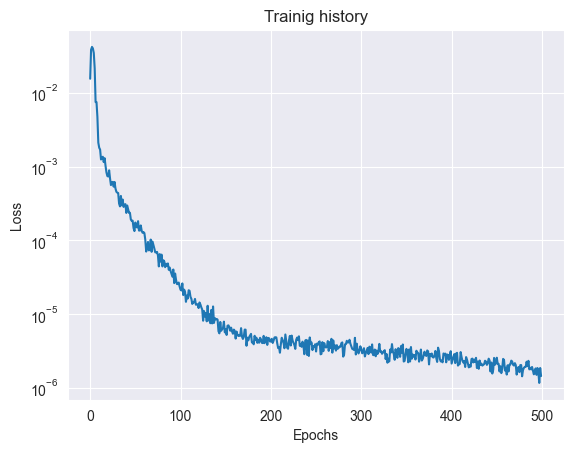

In [9]:
plt.figure()
plt.plot(model_loss, label = 'loss')
plt.yscale('log')
plt.title('Trainig history')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Test the model on a new set of test points.

157/157 [==============================] - 0s 536us/step
mse = 1.5833080211608006e-07


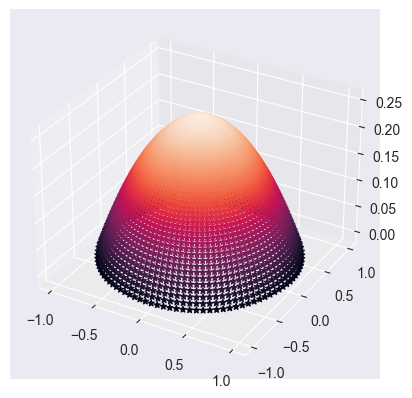

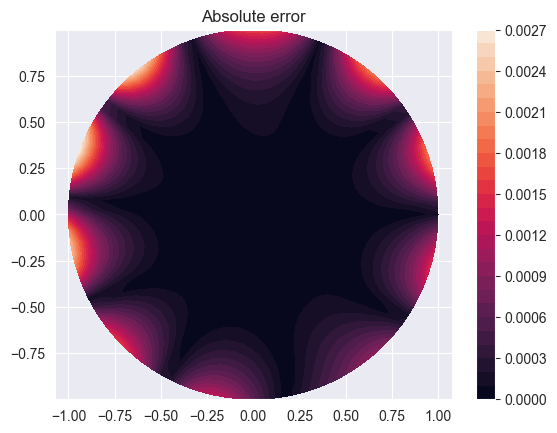

In [10]:
X_test = np.column_stack((xx.reshape(-1,1),yy.reshape(-1,1)))
sol_ref = f_ref(X_test[:,0], X_test[:,1], f)

sol_PINN = model.predict(X_test)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:,0],X_test[:,1],sol_PINN,c = sol_PINN,marker = '*', alpha = 1)
# ax.scatter(X_test[:, 0], X_test[:, 1], sol_ref, marker='o', alpha=.1)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(sol_PINN, sol_ref.reshape(-1, 1))
print('mse =', mse)


plt.figure()
plt.contourf(xx, yy, np.reshape(
    abs(sol_PINN - sol_ref.reshape(-1, 1)), xx.shape), 30)
plt.axis('equal')
plt.colorbar()
plt.title('Absolute error')
plt.show()